## Capstone Project (Week 2) 

# Houseboat in Amsterdam

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction:  <a name="introduction"></a>

I wanted to choose something interesting for the final project, something practically fabulous and devoid of any business core. And then I remembered that once with my friends I dreamed of spending the whole summer in a houseboat in Amsterdam. To be honest, this idea still seems very attractive. So, I decided to imagine that in the near future my friends and I are going to Amsterdam to live in a houseboat. There is only one small task left - to choose it. I dedicated my final project to the solution of this very problem.

**Background**

Amsterdam is a very friendly to tourists. He is waiting for them. And therefore he has a lot of places for the curious traveler. Among the many types of dwellings, Amsterdam is famous for its houseboats. This is probably the most suitable city in the world for this. There are a lot of different houseboats in Amsterdam. Therefore, before the houseboat renting, we need to decide which one to choose. They are all different, have different rental prices, and are located in different parts of the city.

The location is very important for us. We want our houseboat to be located in a comfortable area for life, close to places we are interested in. For example, close to gyms (we will be there for three months, we would not want to lose shape) to museums and historical sites, restaurants, parks, and, finally, to coffee shops with marijuana (this is Amsterdam after all).

Thus, we are faced with several sub-tasks:

- to find a list of all houseboats available for rent in Amsterdam;
- to select the set of houseboats that are most suitable for us in terms of price, visitor reviews, etc. - in terms of the "internal" characteristics of houseboats;
- to find out what venues are around selected houseboats;
- to understand what houseboats clusters exist and in which clusters certain houseboats are located – to find out the "external" characteristics of houseboats;
- to choose the houseboat that suits us the best.


## Data <a name="data"></a>

In order to solve all of the above tasks, I need the following.

Data description. On kaggle.com I found several excellent datasets that contain detailed information about twenty thousand rental places in Amsterdam (hotel rooms, private apartments, hostels, etc., including of course houseboats). The geolocation of all these places, daily and monthly prices, visitor reviews, a cleanliness indicator and much more are in this datasets. In general, this is exactly what I need.
Data source. Here's a link to these datasets https://www.kaggle.com/erikbruin/airbnb-amsterdam 

In addition, I will use the Foursquare location data (Foursquare API) to explore surrounding venues. This will allow me to get data on venues and their categories next to houseboats. I will also use the Folium library to visualize the objects on the Amsterdam map.


## Importing required libraries

In [15]:
# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# Visualization and plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import matplotlib.pyplot as plt
 

# library to handle JSON files
import json

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium

print('Required libraries are imported.')

Required libraries are imported.


In [55]:
#some parameters for plots visualization
sns.set_context("notebook", font_scale = 1.5, rc={"lines.linewidth": 2.5})
sns.set(rc = {'figure.figsize':(9.7, 7.27)})
sns.despine(left = True)
sns.set_context("notebook")
sns.set_style("white")

<Figure size 698.4x523.44 with 0 Axes>

## Downloading and Cleaning the data 'All Airbnb listings in Amsterdam on December 6th, 2018' 

In [17]:
#reading the files with required data

file_1 = pd.read_csv("listings.csv", index_col = "id")
file_2 = pd.read_csv("listings_details.csv", index_col = "id", low_memory = False)

In [ ]:
#creating the list of required columns from file_2

columns = ["property_type", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "weekly_price", "monthly_price"]

In [19]:
#merging the dataframes from file_1 and file_2

common_df = pd.merge(file_1, file_2[target_columns], on = 'id', how = 'left')

In [21]:
#data cleaning

common_df = common_df.drop(['neighbourhood_group', 'minimum_nights', 'calculated_host_listings_count', 'availability_365'], axis = 1)

### Choosing the requiered property type - Houseboats

#### The list of all property types

In [37]:
print('There are', common_df.property_type.nunique(), 'property types in the dataframe')
print('\n')
print('The list of all property types:', *common_df.property_type.unique(), sep='\n')

There are 31 property types in the dataframe


The list of all property types:
Apartment
Townhouse
Houseboat
Bed and breakfast
Boat
Guest suite
Loft
Serviced apartment
House
Boutique hotel
Guesthouse
Other
Condominium
Chalet
Nature lodge
Tiny house
Hotel
Villa
Cabin
Lighthouse
Bungalow
Hostel
Cottage
Tent
Earth house
Campsite
Castle
Camper/RV
Barn
Casa particular (Cuba)
Aparthotel


#### Creating the dataframe with houseboats only

In [38]:
#selecting houseboats data from common dataframe
boats_df = common_df[df.property_type == 'Houseboat']

In [40]:
print('So, there are', boats.shape[0], 'for rent in Amsterdam')

So, there are 225 for rent in Amsterdam


#### There are three types of room

In [47]:
#calculatinf the amount of different room types

room_type = boats_df['room_type'].value_counts().sort_values(ascending = True)

In [49]:
print(room_type)

Shared room          2
Private room        69
Entire home/apt    154
Name: room_type, dtype: int64


<AxesSubplot:>

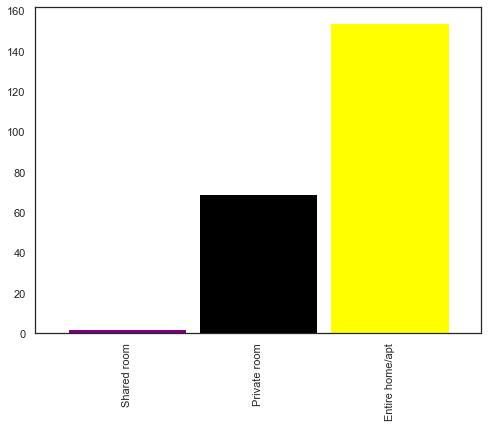

In [56]:
#bar plot with different room types

room_type.plot(kind = 'bar', color = ['purple', 'black', 'yellow'], figsize = (8, 6), width = 0.9)

Our main goal - to rent houseboats for a group of friends for a long period. It is unlikely that we can have a good summer in a *shared room or private room*. We need the **entire home!** 
So, lets select only houseboats with **'Entire home'** type.

In [53]:
#creating the dataframe with 'entire home/apt' types of houseboats

home = boats_df[boats_df.room_type == 'Entire home/apt']
home.shape

(154, 21)

Our dataset contains information about the **daily rental price**, as well as **rating indicators** based on customer reviews. Let's take a look at this data. Most likely, we will not rent low rating or too expensive house.

<AxesSubplot:>

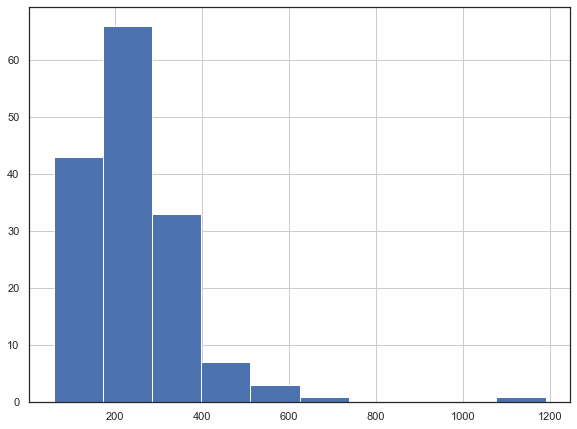

In [57]:
#simple histogram for price
home.price.hist()

<AxesSubplot:xlabel='room_type', ylabel='price'>

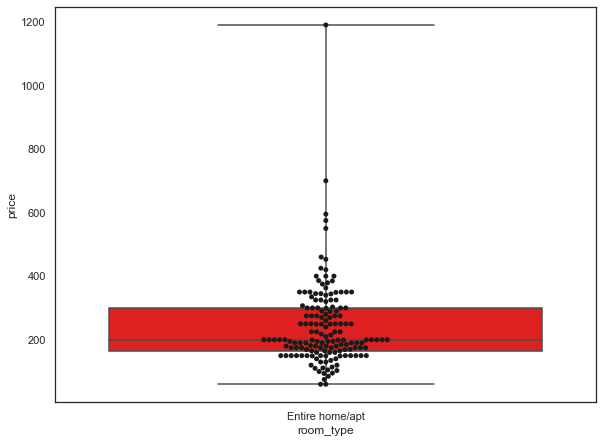

In [58]:
#boxplot for price
sns.boxplot(x = "room_type", y = "price", data = home, whis = np.inf, color = 'red')
sns.swarmplot(x = "room_type", y = "price", data = home, color = ".1")

So, we have few very luxury houseboats. What is about review scores rating?

<AxesSubplot:>

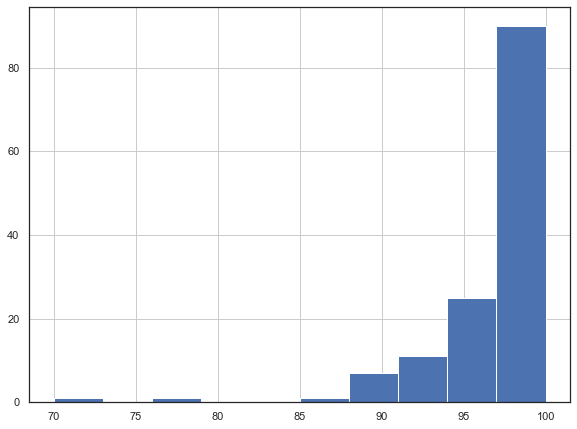

In [59]:
#simple histogram for review scores rating
home.review_scores_rating.hist()

<AxesSubplot:ylabel='Frequency'>

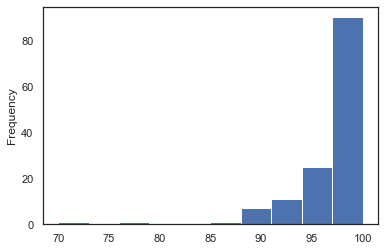

In [434]:
home.review_scores_rating.plot(kind = 'hist')


Here we also see the few outliers. But most scores are more 90.
The last step is to **check the possible relation between price and rating scores**.


<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

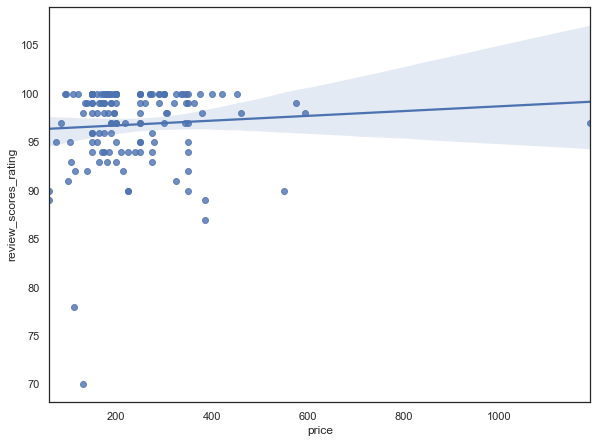

In [60]:
#regression plot to check the type of relation between price and rating
sns.regplot(x = 'price', y = 'review_scores_rating', data = home)

As we see, there is **no link between price and review scores**. Thus, let's remove from our dataset only **overly expensive** homes and homes with very **low ratings**. The above regplot says us that low price homes are also can be very good.

In [65]:
#creating the mask with required conditions
mask = (home.price < 400) & (home.review_scores_rating > 90) 

#creating the last version of the dataframe
df = home[mask]

print('There are', df.shape[0], 'houseboats in the dataframe.')

There are 119 houseboats in the dataframe.


In [71]:
#data cleaning
df = df.drop(['host_name', 'host_id', 'room_type', 'number_of_reviews', 'last_review', 'reviews_per_month', 
              'review_scores_value', 'property_type', 'review_scores_cleanliness', 'review_scores_location', 
              'review_scores_accuracy', 'review_scores_communication', 'review_scores_checkin', 'weekly_price',
              'monthly_price'], axis = 1)              

In [119]:
df.rename(columns = {'name' : 'houseboat'}, inplace = True)

(119, 6)

In [121]:
df.head()

,houseboat,neighbourhood,latitude,longitude,price,review_scores_rating
id,,,,,,
73917,B28 Unique Houseboat Herengracht,Centrum-West,52.378943,4.890602,175,94.0
221943,Cozy Houseboat - Central Amsterdam,De Baarsjes - Oud-West,52.365637,4.876398,170,94.0
627213,House boat near museums in the Pijp,De Pijp - Rivierenbuurt,52.352284,4.887419,150,100.0
771217,Lovely Amsterdam Houseboat,Zuid,52.340747,4.850239,340,100.0
779225,★★★★★ The Amsterdam Floating Mansion,Oostelijk Havengebied - Indische Buurt,52.369062,4.952069,350,95.0


In [436]:
print('There are', df.shape[0], 'houseboats in the dataframe.')

There are 119 houseboats in the dataframe.


### Foursquare

We will use Fousquare API to obtain **Amsterdam geolocation** and to get the list of the main **venues** which are around our houseboats.

In [76]:
# Foursquare ID
CLIENT_ID = 'ETELD55JVCBHVTZJSDJC5L12LCH4O1XFNCL1BP1QR1VUGSH

C'
# Foursquare Secret
CLIENT_SECRET = 'SD4TRVIBZ3N00XB0IUEZFLNWJ0Y4YL3WVTZOLVV1IP1WRFAQ'
# Foursquare API version
VERSION = '20180605' 
# Foursquare API limit value
LIMIT = 100 

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: ETELD55JVCBHVTZJSDJC5L12LCH4O1XFNCL1BP1QR1VUGSHC
CLIENT_SECRET:SD4TRVIBZ3N00XB0IUEZFLNWJ0Y4YL3WVTZOLVV1IP1WRFAQ


In [77]:
#The coordinate of Amsterdam
address = 'Amsterdam, Netherlands'

geolocator = Nominatim(user_agent = "ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Amsterdam are 52.3727598, 4.8936041.


### Let's visualize the map with the location of all houseboats of interest to us.

In [275]:
#creating the map
map_boats = folium.Map(location = [latitude, longitude], zoom_start = 12)

# add markers to map
for lat, lng, name in zip(df['latitude'], df['longitude'], df['houseboat']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'black',
        fill = True,
        fill_color = 'yellow',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_boats)  
    
map_boats

In [ ]:
# creating the function for venues getting

In [276]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [278]:
#creating the new dataframe with venues around houseboats

venues = getNearbyVenues(names = df['houseboat'], latitudes = df['latitude'], longitudes = df['longitude'])

B28 Unique Houseboat  Herengracht
Cozy Houseboat - Central Amsterdam
House boat near museums in the Pijp
Lovely Amsterdam Houseboat
★★★★★ The Amsterdam Floating Mansion
Beautiful houseboat in city center
ADE Houseboat Jordaan in Citycenter
Exclusive Houseboat Amsterdam Center
Perfect Family Houseboat
Spacious Boat-House in hip&trendy district
Houseboat with two master-bedrooms & two bathrooms
lovely houseboat with large terrace
Historic houseboat in city centre
Private Houseboat~City Center
Unique House Boat for family, (kids free)
Modern spacious and cosy houseboat
Antonia Houseboat in Amsterdam
Lovely colourful houseboat
Wonderful houseboat Amsterdam
Family Houseboat in City Center
Beautiful HOUSEBOAT with garden
Unique Amsterdam Houseboat
Sunny Family Houseboat Amstel River
Spacious houseboat for family
Houseboat in Amsterdam city centre
Houseboat near city center
Luxurious houseboat on Amstel River
Spacious Boat with Sunny Terrace
houseboat near centre & westerpark
Floating house
C

In [279]:
print('There are', venues.shape[0], 'venues in the dataframe')

There are 5218 venues are in the dataframe


In [281]:
venues.rename(columns = {'Neighborhood': 'houseboat'}, inplace = True)

In [282]:
venues.head()

,houseboat,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,B28 Unique Houseboat Herengracht,52.378943,4.890602,Barney's Farm,52.380623,4.891079,Diner
1,B28 Unique Houseboat Herengracht,52.378943,4.890602,Abinish,52.380911,4.890341,Steakhouse
2,B28 Unique Houseboat Herengracht,52.378943,4.890602,De Belhamel,52.379421,4.892003,French Restaurant
3,B28 Unique Houseboat Herengracht,52.378943,4.890602,Tenue de Nîmes,52.380511,4.891231,Clothing Store
4,B28 Unique Houseboat Herengracht,52.378943,4.890602,Barney's Coffeeshop,52.380641,4.890922,Marijuana Dispensary


In [438]:
print('There are', venues.shape[0], 'venues in the dataframe')

There are 5218 venues in the dataframe


**FIRST CONCLUSION ABOUT THE DATA**

## Methodology <a name="methodology"></a>

In this project we will

## Analysis <a name="analysis"></a>

#### Let's find out the number of each venue category.

In [283]:
#grouping the vanues dataframe by Venue category

venues.groupby(by = 'Venue Category').count().sort_values(by = 'Venue', ascending = False)

,houseboat,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bar,328,328,328,328,328,328
Café,252,252,252,252,252,252
Coffee Shop,247,247,247,247,247,247
Hotel,231,231,231,231,231,231
Italian Restaurant,224,224,224,224,224,224
Restaurant,199,199,199,199,199,199
French Restaurant,100,100,100,100,100,100
Bakery,98,98,98,98,98,98
Sandwich Place,90,90,90,90,90,90


#### Prepearing the data for clustering

In [284]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
venues_onehot['houseboat'] = venues['houseboat'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,houseboat,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Spanish Restaurant,Speakeasy,Sports Club,Squash Court,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,VR Cafe,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [285]:
#grouping the onehot venues by houseboat

venues_grouped = venues_onehot.groupby('houseboat').mean().reset_index()
venues_grouped.head()

,houseboat,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Spanish Restaurant,Speakeasy,Sports Club,Squash Court,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,VR Cafe,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1910's Completely renovated house boat @ Amstel!,0.0,0.0,0.0,0.013889,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013889,0.0,0.0,0.0,0.0,0.013889,0.041667,0.055556,0.0,0.0,0.013889,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.000000,

In [ ]:
#function for most common venues obtaining

In [286]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [287]:
#creating the dataframe with top ten frequent venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['houseboat']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['houseboat'] = venues_grouped['houseboat']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,houseboat,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1910's Completely renovated house boat @ Amstel!,Italian Restaurant,Bar,Coffee Shop,Hotel,Hotel Bar,Breakfast Spot,Restaurant,Bakery,Indian Restaurant,Steakhouse
1,"5star houseboat@jordaan, indoor terrace+canal...",Bar,Italian Restaurant,Café,Sandwich Place,Coffee Shop,Deli / Bodega,Tapas Restaurant,Market,Marijuana Dispensary,Bistro
2,ADE Houseboat Jordaan in Citycenter,Bar,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Thai Restaurant,Market,Pizza Place,Bistro,Furniture / Home Store
3,"Amazing Houseboat, Premium Spot on Amstel River",Coffee Shop,Café,French Restaurant,Sandwich Place,Gym,Bar,Train Station,Drugstore,Jazz Club,Bookstore
4,Amazing houseboat on Amstel river with sundeck,Bar,Hotel Bar,Hotel,Italian Restaurant,Indian Restaurant,Restaurant,Pizza Place,Café,Coffee Shop,Doner Restaurant


# K-means clustering

#### Unsig the elbow method to find out the optimal k

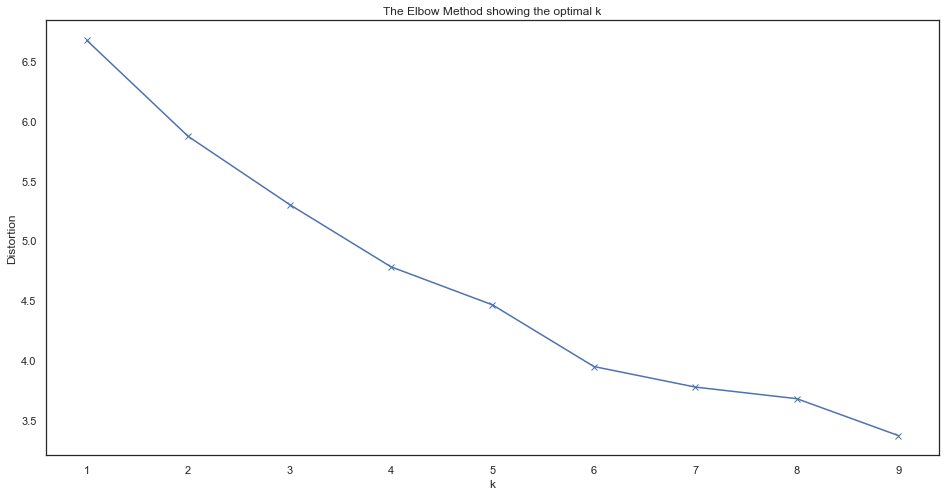

In [288]:
# variant 1  (using euclidian distance)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(venues_grouped.drop('houseboat', 1))
    distortions.append(kmeanModel.inertia_)
 
 # plotting the elbow

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()    

Comment

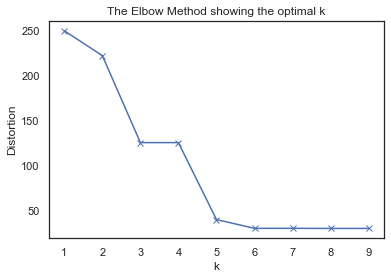

In [289]:
#variant 2 (using correlation distance)

from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(venues_grouped.drop('houseboat', 1))
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(venues_grouped.drop('houseboat', 1), kmeanModel.cluster_centers_, 'canberra'), axis=1)) / venues_grouped.drop('houseboat', 1).shape[0])

 # plottting the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

So, it is not an easy situation. Let's try to create **4 clusters**.
To add something more!

#### K-means clustering

In [290]:
# set number of clusters
kclusters = 4

venues_grouped_clustering = venues_grouped.drop('houseboat', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(venues_grouped_clustering)

In [291]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 2, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 3,
       0, 2, 1, 0, 0, 0, 0, 0, 2])

In [292]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

venue_merged = df

# merge venue_grouped with common df to add latitude/longitude for each houseboat
venue_merged = venue_merged.join(neighborhoods_venues_sorted.set_index('houseboat'), on = 'houseboat')

venue_merged.head() 

,houseboat,neighbourhood,latitude,longitude,price,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
id,,,,,,,,,,,,,,,,,
73917,B28 Unique Houseboat Herengracht,Centrum-West,52.378943,4.890602,175,94.0,0,Bar,Café,Hotel,Italian Restaurant,Deli / Bodega,Marijuana Dispensary,Sandwich Place,Bike Rental / Bike Share,French Restaurant,Thai Restaurant
221943,Cozy Houseboat - Central Amsterdam,De Baarsjes - Oud-West,52.365637,4.876398,170,94.0,0,Bar,Hotel,Indonesian Restaurant,Restaurant,Italian Restaurant,French Restaurant,Theater,Gym / Fitness Center,Caribbean Restaurant,Bike Rental / Bike Share
627213,House boat near museums in the Pijp,De Pijp - Rivierenbuurt,52.352284,4.887419,150,100.0,0,Pizza Place,Breakfast Spot,Salad Place,Italian Restaurant,Coffee Shop,Mediterranean Restaurant,South American Restaurant,Steakhouse,Japanese Restaurant,French Restaurant
771217,Lovely Amsterdam Houseboat,Zuid,52.340747,4.850239,340,100.0,1,Restaurant,Tennis Court,Stadium,Bakery,Harbor / Marina,Skating Rink,Gym,Gym / Fitness Center,Soccer Field,Hotel
779225,★★★★★ The Amsterdam Floating Mansion,Oostelijk Havengebied - Indische Buurt,52.369062,4.952069,350,95.0,2,Harbor / Marina,Arts & Entertainment,Lounge,Pool,Tram Station,Gym,Café,Empanada Restaurant,Ethiopian Restaurant,Event Space


### Creating the map with clusters

In [293]:
# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venue_merged['latitude'], venue_merged['longitude'], venue_merged['houseboat'], venue_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In [294]:
# creating the dataframes for each clusters

cluster_0 = venue_merged.loc[venue_merged['Cluster Labels'] == 0, venue_merged.columns[[1] + list(range(5, venue_merged.shape[1]))]]
cluster_1 = venue_merged.loc[venue_merged['Cluster Labels'] == 1, venue_merged.columns[[1] + list(range(5, venue_merged.shape[1]))]]
cluster_2 = venue_merged.loc[venue_merged['Cluster Labels'] == 2, venue_merged.columns[[1] + list(range(5, venue_merged.shape[1]))]]
cluster_3 = venue_merged.loc[venue_merged['Cluster Labels'] == 3, venue_merged.columns[[1] + list(range(5, venue_merged.shape[1]))]]

### Cluster 0

In [295]:
cluster_0.head()

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
id,,,,,,,,,,,,,
73917,Centrum-West,94.0,0,Bar,Café,Hotel,Italian Restaurant,Deli / Bodega,Marijuana Dispensary,Sandwich Place,Bike Rental / Bike Share,French Restaurant,Thai Restaurant
221943,De Baarsjes - Oud-West,94.0,0,Bar,Hotel,Indonesian Restaurant,Restaurant,Italian Restaurant,French Restaurant,Theater,Gym / Fitness Center,Caribbean Restaurant,Bike Rental / Bike Share
627213,De Pijp - Rivierenbuurt,100.0,0,Pizza Place,Breakfast Spot,Salad Place,Italian Restaurant,Coffee Shop,Mediterranean Restaurant,South American Restaurant,Steakhouse,Japanese Restaurant,French Restaurant
791690,Centrum-West,99.0,0,Bar,Café,Sandwich Place,Hotel,Deli / Bodega,Marijuana Dispensary,Italian Restaurant,Dessert Shop,French Restaurant,Bistro
839139,Centrum-West,100.0,0,Bar,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Thai Restaurant,Market,Pizza Place,Bistro,Furniture / Home Store


#### 1st Most Common Venues for cluster 0

In [296]:
# 1st Most Common Venues for cluster 0

cluster_0_common = cluster_0.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Cluster Labels', ascending = False)
cluster_0_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bar,25,25,25,25,25,25,25,25,25,25,25,25
15,Restaurant,14,14,14,14,14,14,14,14,14,14,14,14
7,Hotel,14,14,14,14,14,14,14,14,14,14,14,14
4,Coffee Shop,11,11,11,11,11,11,11,11,11,11,11,11
3,Café,6,6,6,6,6,6,6,6,6,6,6,6
9,Italian Restaurant,5,5,5,5,5,5,5,5,5,5,5,5
8,Hotel Bar,4,4,4,4,4,4,4,4,4,4,4,4
12,Pizza Place,2,2,2,2,2,2,2,2,2,2,2,2
11,Pharmacy,2,2,2,2,2,2,2,2,2,2,2,2
16,Yoga Studio,1,1,1,1,1,1,1,1,1,1,1,1


### Cluster 1

In [297]:
cluster_1.head()

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
id,,,,,,,,,,,,,
771217,Zuid,100.0,1,Restaurant,Tennis Court,Stadium,Bakery,Harbor / Marina,Skating Rink,Gym,Gym / Fitness Center,Soccer Field,Hotel
6455099,Zuid,98.0,1,Tennis Court,Restaurant,Harbor / Marina,Forest,Hotel,Soccer Field,Stadium,Men's Store,Gym / Fitness Center,Italian Restaurant
12500365,Zuid,100.0,1,Tennis Court,Restaurant,Bakery,Soccer Field,Office,Intersection,Forest,Harbor / Marina,Hotel,Gas Station
19194656,Zuid,97.0,1,Tennis Court,Restaurant,Stadium,Forest,Bakery,Office,Harbor / Marina,Gym / Fitness Center,Soccer Field,Hotel
22716592,Zuid,100.0,1,Tennis Court,Restaurant,Gym / Fitness Center,Stadium,Harbor / Marina,Skating Rink,Gym,Bakery,Soccer Field,Hotel


#### 1st Most Common Venues for cluster 1

In [298]:
# 1st Most Common Venues for cluster 1

cluster_1_common = cluster_1.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Cluster Labels', ascending = False)
cluster_1_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Tennis Court,4,4,4,4,4,4,4,4,4,4,4,4
0,Restaurant,1,1,1,1,1,1,1,1,1,1,1,1


### Cluster 2

In [299]:
cluster_2.head()

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
id,,,,,,,,,,,,,
779225,Oostelijk Havengebied - Indische Buurt,95.0,2,Harbor / Marina,Arts & Entertainment,Lounge,Pool,Tram Station,Gym,Café,Empanada Restaurant,Ethiopian Restaurant,Event Space
3144548,Oostelijk Havengebied - Indische Buurt,97.0,2,Playground,Tunnel,Bus Stop,Bed & Breakfast,Plaza,Cosmetics Shop,Dance Studio,Deli / Bodega,Flower Shop,Flea Market
3408419,Watergraafsmeer,97.0,2,Garden,Harbor / Marina,Bed & Breakfast,Cocktail Bar,Bar,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
6982667,Noord-West,92.0,2,Pool,Bookstore,Gym,Farm,Café,Soccer Field,Bus Stop,Monument / Landmark,Fast Food Restaurant,Farmers Market
10379281,Noord-West,98.0,2,Bus Stop,Supermarket,Shopping Mall,Pharmacy,Bookstore,Furniture / Home Store,Farm,Ethiopian Restaurant,Event Space,Falafel Restaurant


#### 1st Most Common Venues for cluster 2

In [300]:
# 1st Most Common Venues for cluster 2

cluster_2_common = cluster_2.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Cluster Labels', ascending = False)
cluster_2_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bus Stop,4,4,4,4,4,4,4,4,4,4,4,4
5,Harbor / Marina,2,2,2,2,2,2,2,2,2,2,2,2
1,Cosmetics Shop,1,1,1,1,1,1,1,1,1,1,1,1
2,Coworking Space,1,1,1,1,1,1,1,1,1,1,1,1
3,Furniture / Home Store,1,1,1,1,1,1,1,1,1,1,1,1
4,Garden,1,1,1,1,1,1,1,1,1,1,1,1
6,Lake,1,1,1,1,1,1,1,1,1,1,1,1
7,Playground,1,1,1,1,1,1,1,1,1,1,1,1
8,Pool,1,1,1,1,1,1,1,1,1,1,1,1
9,Snack Place,1,1,1,1,1,1,1,1,1,1,1,1


### Cluster 3

In [301]:
cluster_3.head()

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
id,,,,,,,,,,,,,
5836389,IJburg - Zeeburgereiland,94.0,3,Coworking Space,Harbor / Marina,Neighborhood,Bed & Breakfast,Flower Shop,Park,Tram Station,Food & Drink Shop,Pier,Empanada Restaurant
7448305,IJburg - Zeeburgereiland,95.0,3,Bed & Breakfast,Hotel,Coworking Space,Food & Drink Shop,Pier,Flower Shop,Harbor / Marina,Mediterranean Restaurant,Tram Station,Neighborhood
13632710,IJburg - Zeeburgereiland,92.0,3,Coworking Space,Harbor / Marina,Neighborhood,Bed & Breakfast,Flower Shop,Park,Tram Station,Food & Drink Shop,Pier,Empanada Restaurant
22696688,IJburg - Zeeburgereiland,100.0,3,Coworking Space,Harbor / Marina,Neighborhood,Bed & Breakfast,Flower Shop,Park,Tram Station,Food & Drink Shop,Pier,Empanada Restaurant
23839946,IJburg - Zeeburgereiland,100.0,3,Coworking Space,Harbor / Marina,Neighborhood,Bed & Breakfast,Flower Shop,Park,Tram Station,Food & Drink Shop,Pier,Empanada Restaurant


#### 1st Most Common Venues for cluster 3

In [302]:
# 1st Most Common Venues for cluster 3

cluster_3_common = cluster_3.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Cluster Labels', ascending = False)
cluster_3_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Coworking Space,5,5,5,5,5,5,5,5,5,5,5,5
0,Bed & Breakfast,1,1,1,1,1,1,1,1,1,1,1,1
2,Park,1,1,1,1,1,1,1,1,1,1,1,1


#### Common plot to visualize the frequency of differet venues in each cluster

In [303]:
#dataframe formation

venues_number = venue_merged
venues_number = venues_number.drop(['neighbourhood','latitude', 'longitude', 'price', 'review_scores_rating'], axis = 1)
venues_number = venues_number.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name = 'number')

#transposing the dataframe

clusters = venues_number.pivot(index = 'Cluster Labels', columns = '1st Most Common Venue', values = 'number')
clusters = clusters.fillna(0).astype(int).reset_index(drop = True)
clusters

1st Most Common Venue,Bakery,Bar,Bed & Breakfast,Brasserie,Bus Stop,Café,Coffee Shop,Cosmetics Shop,Coworking Space,Department Store,Ethiopian Restaurant,Furniture / Home Store,Garden,Harbor / Marina,Hotel,Hotel Bar,Italian Restaurant,Lake,Nightclub,Park,Pharmacy,Pizza Place,Playground,Plaza,Pool,Restaurant,Snack Place,Sports Club,Tennis Court,Yoga Studio,Zoo Exhibit
0,1,25,0,1,0,6,11,0,0,1,1,0,0,0,14,4,5,0,1,0,2,2,0,1,1,14,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0
2,0,0,0,0,4,0,0,1,1,0,0,1,1,2,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0
3,0,0,1,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Venue Count')

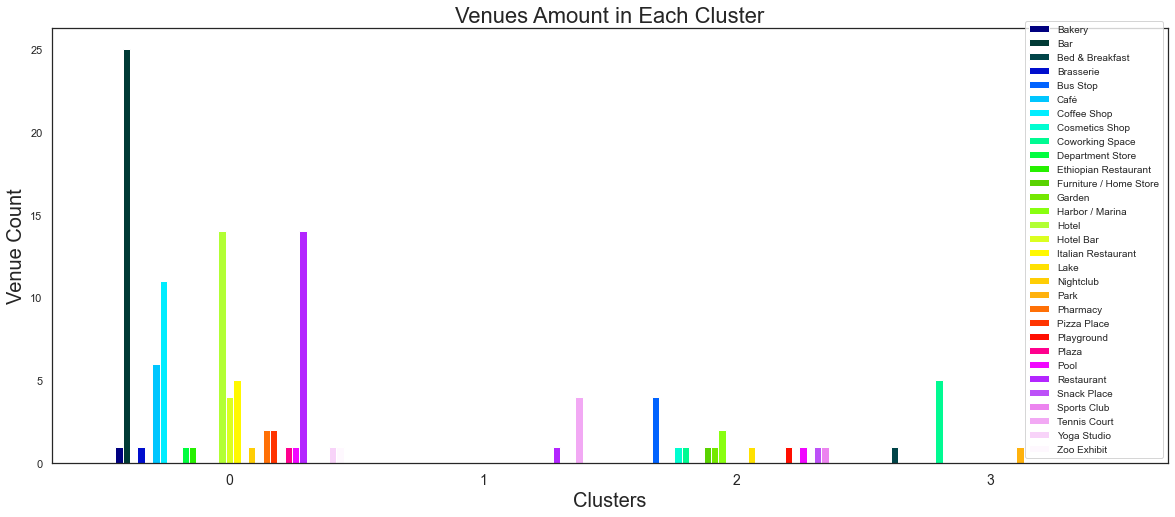

In [304]:
#bar chart with the "Number of Venues in Each Cluster"

graph = clusters.plot(kind = 'bar', figsize = (20,8), width = 0.9, colormap = 'gist_ncar')

plt.legend(labels = clusters.columns, fontsize = 10)
plt.title("Venues Amount in Each Cluster", fontsize = 22)
plt.xticks(fontsize = 14)
plt.xticks(rotation = 0)
plt.xlabel('Clusters', fontsize = 20)
plt.ylabel('Venue Count', fontsize = 20)

#### Small conclusion

### Let's repeat our analysis. 

But this time we will divide all our **venues** into ***two categories***. 
We will include all **catering places** in *one category* (bars, restaurants, cafes etc.).
In another category, we include **recreational sites, historical sites, gyms, plazas, etc.** In general, we will exclude food establishments, hotels, bus stops, supermarkets, etc. from the general list. A detailed list will be given below during the direct data processing.

#### Let's name the first group - Food group

In [271]:
# the list of venues for our new Food group

food_list = ['Bar', 'Coffee', 'Café', 'Restaurant', 'Bakery', 'Sandwich', 'Pizza', 'Diner', 'Bistro', 'Gastropub', 'Dessert', 
             'Snack', 'Steakhouse', 'BBQ Joint', 'Bodega', 'Organic Grocery', 'Burger Joint', 'Joint', 'Salad', 'Creperie', 
             'Burrito', 'Soup', 'Taco', 'Tea', 'Brewery', 'Brasserie', 'Friterie', 'Cafeteria', 'Pub']

print(food_list)

['Bar', 'Coffee', 'Café', 'Restaurant', 'Bakery', 'Sandwich', 'Pizza', 'Diner', 'Bistro', 'Gastropub', 'Dessert', 'Snack', 'Steakhouse', 'BBQ Joint', 'Bodega', 'Organic Grocery', 'Burger Joint', 'Joint', 'Salad', 'Creperie', 'Burrito', 'Soup', 'Taco', 'Tea', 'Brewery', 'Brasserie', 'Friterie', 'Cafeteria', 'Pub']


In [308]:
#small loop to obtain indices of required venues in the total venues dataframe

food_index_list = []

for i in range(0, venues.shape[0]):
    for j in food_list:
        if j in venues['Venue Category'][i]:
            food_index_list.append(i)            

In [309]:
len(food_index_list)

3184

In [310]:
# creating new dataframe with catering places only

food = venues.iloc[food_index_list, :]
food = food.reset_index().drop("index", axis = 1)

In [321]:
print('There are', food.shape[0], 'venues in the food dataframe')

There are 3184 venues in the food dataframe


In [320]:
food.head()

,houseboat,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,B28 Unique Houseboat Herengracht,52.378943,4.890602,Barney's Farm,52.380623,4.891079,Diner
1,B28 Unique Houseboat Herengracht,52.378943,4.890602,Abinish,52.380911,4.890341,Steakhouse
2,B28 Unique Houseboat Herengracht,52.378943,4.890602,De Belhamel,52.379421,4.892003,French Restaurant
3,B28 Unique Houseboat Herengracht,52.378943,4.890602,Proeflokaal Arendsnest,52.376769,4.889399,Beer Bar
4,B28 Unique Houseboat Herengracht,52.378943,4.890602,Il Tramezzino,52.380359,4.891610,Sandwich Place


#### Repeating the all steps for clustering analysis

In [322]:
#grouping the food vanues dataframe by Venue category

food.groupby(by = 'Venue Category').count().sort_values(by = 'Venue', ascending = False)

,houseboat,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bar,328,328,328,328,328,328
Café,252,252,252,252,252,252
Coffee Shop,247,247,247,247,247,247
Italian Restaurant,224,224,224,224,224,224
Restaurant,199,199,199,199,199,199
French Restaurant,100,100,100,100,100,100
Bakery,98,98,98,98,98,98
Sandwich Place,90,90,90,90,90,90
Pizza Place,89,89,89,89,89,89


In [323]:
# one hot encoding
food_onehot = pd.get_dummies(food[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
food_onehot['houseboat'] = food['houseboat'] 

# move neighborhood column to the first column
fixed_columns = [food_onehot.columns[-1]] + list(food_onehot.columns[:-1])
food_onehot = food_onehot[fixed_columns]

food_onehot.head()

,houseboat,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Brasserie,Brewery,Burger Joint,Burrito Place,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Creperie,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Gastropub,Gay Bar,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hookah Bar,Hot Dog Joint,Hotel Bar,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Organic Grocery,Persian Restaurant,Peruvian Restaurant,Pizza Place,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [324]:
#grouping the onehot venues by houseboat

food_grouped = food_onehot.groupby('houseboat').mean().reset_index()
food_grouped.head()

,houseboat,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Brasserie,Brewery,Burger Joint,Burrito Place,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Creperie,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Gastropub,Gay Bar,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hookah Bar,Hot Dog Joint,Hotel Bar,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Organic Grocery,Persian Restaurant,Peruvian Restaurant,Pizza Place,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,1910's Completely renovated house boat @ Amstel!,0.0,0.0,0.019231,0.0,0.0,0.019231,0.0,0.0,0.057692,0.076923,0.019231,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.038462,0.019231,0.019231,0.0,0.076923,0.000000,0.0,0.000000,0.000000,0.019231,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.019231,0.0,0.0,0.019231,0.0,0.0,0.019231,0.0,0.019231,0.0,0.057692,0.038462,0.000000,0.0,0.115385,0.0,0.019231,0.019231,0.0,0.0,0.0,0.0,0.0,0.000000,0.038462,0.019231,0.0,0.019231,0.019231,0.0,0.0,0.038462,0.000000,0.000000,0.057692,0.000000,0.0,0.019231,0.0,0.000000,0.019231,0.0,0.0,0.0,0.0,0.038462,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.019231
1,"5star houseboat@jordaan, indoor terrace+canal...",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.185185,0.018519,0.037037,0.0,0.0,0.0,0.000000,0.000000,0.092593,0.000000,0.000000,0.0,0.055556,0.000000,0.0,0.055556,0.037037,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.018519,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.018519,0.000000,0.0,0.111111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.018519,0.0,0.0,0.000000,0.000000,0.018519,0.018519,0.018519,0.0,0.074074,0.0,0.018519,0.000000,0.0,0.0,0.0,0.0,0.037037,0.0,0.018519,0.037037,0.0,0.037037,0.0,0.018519,0.0,0.0,0.018519,0.0,0.0,0.000000
2,ADE Houseboat Jordaan in Citycenter,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.018519,0.166667,0.000000,0.037037,0.0,0.0,0.0,0.018519,0.000000,0.092593,0.000000,0.018519,0.0,0.111111,0.018519,0.0,0.018519,0.018519,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.018519,0.018519,0.0,0.092593,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.018519,0.000000,0.000000,0.0,0.000000,0.037037,0.0,0.0,0.037037,0.018519,0.018519,0.000000,0.018519,0.0,0.055556,0.0,0.018519,0.018519,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.018519,0.0,0.055556,0.0,0.000000,0.0,0.0,0.018519,0.0,0.0,0.018519
3,"Amazing Houseboat, Premium Spot on Amstel River",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.083333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.083333,0.166667,0.000000,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.083333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000

In [326]:
#creating the dataframe with top ten frequent venues

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['houseboat']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
food_neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
food_neighborhoods_venues_sorted['houseboat'] = food_grouped['houseboat']

for ind in np.arange(food_grouped.shape[0]):
    food_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(food_grouped.iloc[ind, :], num_top_venues)

food_neighborhoods_venues_sorted.head()

,houseboat,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1910's Completely renovated house boat @ Amstel!,Italian Restaurant,Coffee Shop,Bar,Restaurant,Bakery,Hotel Bar,Indian Restaurant,Middle Eastern Restaurant,Pizza Place,Steakhouse
1,"5star houseboat@jordaan, indoor terrace+canal...",Bar,Italian Restaurant,Café,Sandwich Place,Coffee Shop,Deli / Bodega,Diner,Bistro,Tapas Restaurant,Dessert Shop
2,ADE Houseboat Jordaan in Citycenter,Bar,Coffee Shop,Italian Restaurant,Café,Thai Restaurant,Sandwich Place,Bistro,Pizza Place,Organic Grocery,Wine Bar
3,"Amazing Houseboat, Premium Spot on Amstel River",Coffee Shop,French Restaurant,Café,Fast Food Restaurant,Italian Restaurant,Sandwich Place,Bar,Pizza Place,Cafeteria,Empanada Restaurant
4,Amazing houseboat on Amstel river with sundeck,Bar,Indian Restaurant,Hotel Bar,Italian Restaurant,Pizza Place,Restaurant,Café,Coffee Shop,Greek Restaurant,French Restaurant


### K-means clustering and elbow method

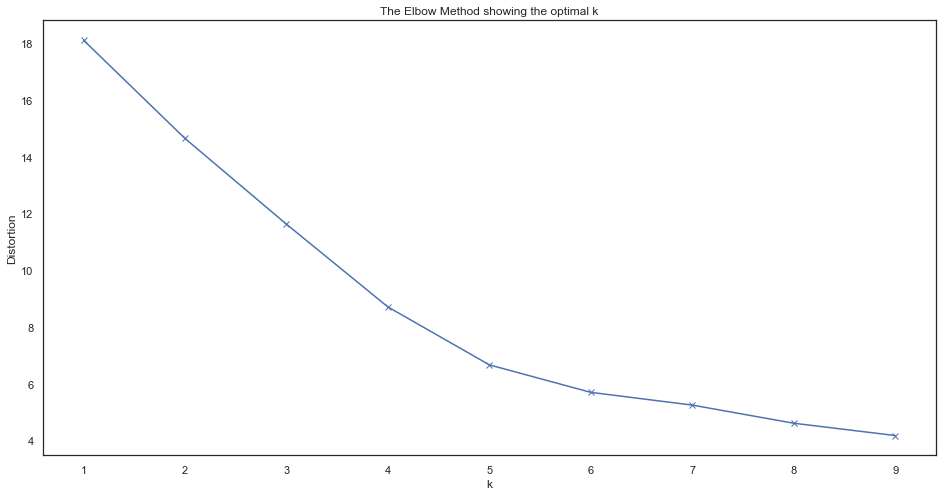

In [328]:
# variant 1  (using euclidian distance)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(food_grouped.drop('houseboat', 1))
    distortions.append(kmeanModel.inertia_)
 
 # plotting the elbow

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()    

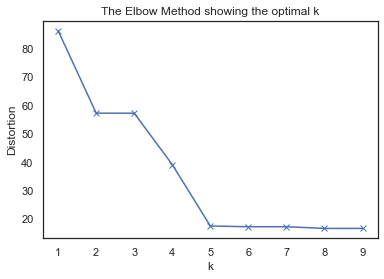

In [329]:
#variant 2 (using correlation distance)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(food_grouped.drop('houseboat', 1))
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(food_grouped.drop('houseboat', 1), kmeanModel.cluster_centers_, 'canberra'), axis=1)) / food_grouped.drop('houseboat', 1).shape[0])

 # plottting the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

So, it is not easy again. Let's try to create **5 clusters**. 

#### K-means clustering

In [330]:
# set number of clusters

kclusters = 5

food_grouped_clustering = food_grouped.drop('houseboat', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(food_grouped_clustering)

In [331]:
# check cluster labels generated for each row in the dataframe

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 3, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 4, 0, 2, 0, 0, 0, 0, 0,
       1])

In [333]:
# add clustering labels

food_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

food_merged = df

# merge food_grouped with common df to add latitude/longitude for each houseboat
food_merged = food_merged.join(food_neighborhoods_venues_sorted.set_index('houseboat'), on = 'houseboat')

#data cleaning
food_merged.dropna(axis = 0, inplace = True)
food_merged['Clusters'] = food_merged['Cluster Labels'].astype('int32')

food_merged.head() 

,houseboat,neighbourhood,latitude,longitude,price,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
id,,,,,,,,,,,,,,,,,
73917,B28 Unique Houseboat Herengracht,Centrum-West,52.378943,4.890602,175,94.0,0.0,Bar,Café,Italian Restaurant,Deli / Bodega,Sandwich Place,French Restaurant,Thai Restaurant,Indian Restaurant,Argentinian Restaurant,Diner
221943,Cozy Houseboat - Central Amsterdam,De Baarsjes - Oud-West,52.365637,4.876398,170,94.0,0.0,Bar,French Restaurant,Indonesian Restaurant,Italian Restaurant,Restaurant,Burger Joint,Coffee Shop,Peruvian Restaurant,Sandwich Place,Caribbean Restaurant
627213,House boat near museums in the Pijp,De Pijp - Rivierenbuurt,52.352284,4.887419,150,100.0,0.0,Pizza Place,Italian Restaurant,Coffee Shop,Mediterranean Restaurant,Salad Place,Indian Restaurant,Bakery,Burger Joint,Japanese Restaurant,French Restaurant
771217,Lovely Amsterdam Houseboat,Zuid,52.340747,4.850239,340,100.0,2.0,Restaurant,Bakery,Fast Food Restaurant,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant
779225,★★★★★ The Amsterdam Floating Mansion,Oostelijk Havengebied - Indische Buurt,52.369062,4.952069,350,95.0,1.0,Café,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant


In [341]:
# create map

map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(food_merged['latitude'], food_merged['longitude'], food_merged['houseboat'], food_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In [342]:
# creating the dataframes for each clusters

food_cluster_0 = food_merged.loc[food_merged['Clusters'] == 0, food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]
food_cluster_1 = food_merged.loc[food_merged['Clusters'] == 1, food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]
food_cluster_2 = food_merged.loc[food_merged['Clusters'] == 2, food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]
food_cluster_3 = food_merged.loc[food_merged['Clusters'] == 3, food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]
food_cluster_4 = food_merged.loc[food_merged['Clusters'] == 4, food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]

### Food Cluster 0

In [441]:
food_cluster_0.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
73917,Centrum-West,94.0,0.0,Bar,Café,Italian Restaurant,Deli / Bodega,Sandwich Place,French Restaurant,Thai Restaurant,Indian Restaurant,Argentinian Restaurant,Diner,0
221943,De Baarsjes - Oud-West,94.0,0.0,Bar,French Restaurant,Indonesian Restaurant,Italian Restaurant,Restaurant,Burger Joint,Coffee Shop,Peruvian Restaurant,Sandwich Place,Caribbean Restaurant,0
627213,De Pijp - Rivierenbuurt,100.0,0.0,Pizza Place,Italian Restaurant,Coffee Shop,Mediterranean Restaurant,Salad Place,Indian Restaurant,Bakery,Burger Joint,Japanese Restaurant,French Restaurant,0
791690,Centrum-West,99.0,0.0,Bar,Café,Sandwich Place,Deli / Bodega,Italian Restaurant,Bistro,Thai Restaurant,French Restaurant,Dessert Shop,Indian Restaurant,0
839139,Centrum-West,100.0,0.0,Bar,Coffee Shop,Italian Restaurant,Café,Thai Restaurant,Sandwich Place,Bistro,Pizza Place,Organic Grocery,Wine Bar,0
1079499,Oud-Oost,98.0,0.0,Italian Restaurant,Coffee Shop,Bar,Café,Restaurant,Hotel Bar,Steakhouse,Bakery,Modern European Restaurant,Middle Eastern Restaurant,0
1381448,Westerpark,98.0,0.0,Restaurant,Coffee Shop,Bar,Bakery,Italian Restaurant,Pizza Place,BBQ Joint,Café,Organic Grocery,Tapas Restaurant,0
1756765,De Baarsjes - Oud-West,93.0,0.0,Ethiopian Restaurant,Coffee Shop,Beer Bar,Moroccan Restaurant,Café,Bakery,French Restaurant,Italian Restaurant,Falafel Restaurant,Latin American Restaurant,0
1927634,Oostelijk Havengebied - Indische Buurt,97.0,0.0,Restaurant,Gastropub,Deli / Bodega,Spanish Restaurant,Italian Restaurant,Diner,Bakery,French Restaurant,Café,Ethiopian Restaurant,0


In [344]:
# 1st Most Common Venues for food cluster 0

food_cluster_0_common = food_cluster_0.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
food_cluster_0_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
1,Bar,33,33,33,33,33,33,33,33,33,33,33,33,33
7,Coffee Shop,16,16,16,16,16,16,16,16,16,16,16,16,16
14,Restaurant,13,13,13,13,13,13,13,13,13,13,13,13,13
12,Italian Restaurant,9,9,9,9,9,9,9,9,9,9,9,9,9
5,Café,6,6,6,6,6,6,6,6,6,6,6,6,6
0,BBQ Joint,5,5,5,5,5,5,5,5,5,5,5,5,5
11,Hotel Bar,3,3,3,3,3,3,3,3,3,3,3,3,3
8,Ethiopian Restaurant,2,2,2,2,2,2,2,2,2,2,2,2,2
2,Bistro,1,1,1,1,1,1,1,1,1,1,1,1,1
3,Brasserie,1,1,1,1,1,1,1,1,1,1,1,1,1


### Food Cluster 1

In [442]:
food_cluster_1.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
779225,Oostelijk Havengebied - Indische Buurt,95.0,1.0,Café,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,1
6982667,Noord-West,92.0,1.0,Café,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,1
14370482,De Pijp - Rivierenbuurt,97.0,1.0,Pizza Place,Café,Wine Bar,Deli / Bodega,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,1
14725283,Oostelijk Havengebied - Indische Buurt,95.0,1.0,Café,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,1
24035311,Oostelijk Havengebied - Indische Buurt,95.0,1.0,Café,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,1
28903055,Watergraafsmeer,100.0,1.0,Café,Restaurant,Sandwich Place,Ethiopian Restaurant,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,1


In [346]:
# 1st Most Common Venues for food cluster 1

food_cluster_1_common = food_cluster_1.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
food_cluster_1_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
0,Café,5,5,5,5,5,5,5,5,5,5,5,5,5
1,Pizza Place,1,1,1,1,1,1,1,1,1,1,1,1,1


### Food Cluster 2

In [446]:
food_cluster_2.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
771217,Zuid,100.0,2.0,Restaurant,Bakery,Fast Food Restaurant,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,2
6455099,Zuid,98.0,2.0,Restaurant,Italian Restaurant,Cafeteria,Falafel Restaurant,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,2
12500365,Zuid,100.0,2.0,Restaurant,Bakery,Fast Food Restaurant,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,2
19194656,Zuid,97.0,2.0,Restaurant,Bakery,Fast Food Restaurant,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,2
22716592,Zuid,100.0,2.0,Restaurant,Bakery,Fast Food Restaurant,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,2
26564269,Noord-Oost,100.0,2.0,Restaurant,Hotel Bar,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,2


In [348]:
# 1st Most Common Venues for food cluster 2

food_cluster_2_common = food_cluster_2.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
food_cluster_2_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
0,Restaurant,6,6,6,6,6,6,6,6,6,6,6,6,6


### Food Cluster 3

In [447]:
food_cluster_3.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
20956533,Oostelijk Havengebied - Indische Buurt,92.0,3.0,Chinese Restaurant,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,3
22099248,Noord-West,100.0,3.0,Chinese Restaurant,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,3
22670935,Noord-West,100.0,3.0,Chinese Restaurant,Wine Bar,Creperie,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,3


In [350]:
# 1st Most Common Venues for food cluster 3

food_cluster_3_common = food_cluster_3.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
food_cluster_3_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
0,Chinese Restaurant,3,3,3,3,3,3,3,3,3,3,3,3,3


### Food Cluster 4

In [448]:
food_cluster_4.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
7448305,IJburg - Zeeburgereiland,95.0,4.0,Mediterranean Restaurant,Hotel Bar,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,4
28269732,IJburg - Zeeburgereiland,100.0,4.0,Mediterranean Restaurant,Hotel Bar,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,4


In [352]:
# 1st Most Common Venues for food cluster 4

food_cluster_4_common = food_cluster_4.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
food_cluster_4_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
0,Mediterranean Restaurant,2,2,2,2,2,2,2,2,2,2,2,2,2


#### Plot to visualize the frequency of differet venues in each food cluster

In [353]:
#dataframe formation

food_venues_number = food_merged
food_venues_number = food_venues_number.drop(['neighbourhood','latitude', 'longitude', 'price', 'review_scores_rating', 'Cluster Labels'], axis = 1)
food_venues_number = food_venues_number.groupby(['Clusters','1st Most Common Venue']).size().reset_index(name = 'number')

#transposing the dataframe

food_clusters = food_venues_number.pivot(index = 'Clusters', columns = '1st Most Common Venue', values = 'number')
food_clusters = food_clusters.fillna(0).astype(int).reset_index(drop = True)
food_clusters

1st Most Common Venue,BBQ Joint,Bar,Bistro,Brasserie,Burger Joint,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Ethiopian Restaurant,Fast Food Restaurant,Greek Restaurant,Hotel Bar,Italian Restaurant,Mediterranean Restaurant,Pizza Place,Restaurant
0,5,33,1,1,1,6,0,1,16,2,1,1,3,9,0,1,13
1,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0


Text(0, 0.5, 'Food Venue Count')

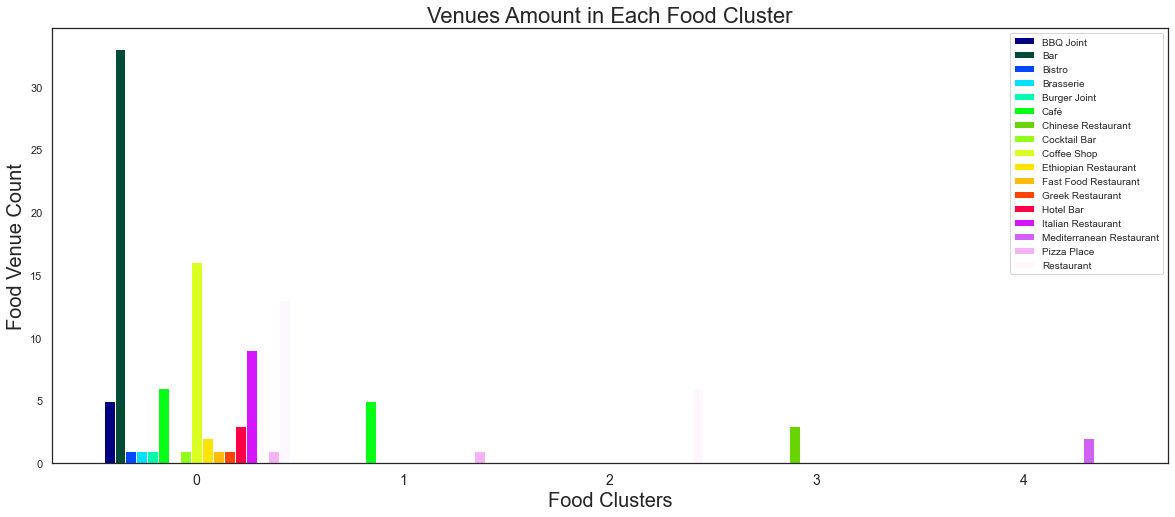

In [355]:
# bar chart with the "Number of Venues in Each Cluster"

food_graph = food_clusters.plot(kind = 'bar', figsize = (20,8), width = 0.9, colormap = 'gist_ncar')

plt.legend(labels = food_clusters.columns, fontsize = 10)
plt.title("Venues Amount in Each Food Cluster", fontsize = 22)
plt.xticks(fontsize = 14)
plt.xticks(rotation = 0)
plt.xlabel('Food Clusters', fontsize = 20)
plt.ylabel('Food Venue Count', fontsize = 20)

#### Small conclusion

## Let's name the second group - No_Food group

In [398]:
# the list of venues to exclude from the common venues dataframe

unwanted_venues_list = ['Bar', 'Shop', 'Coffee', 'Café', 'Hotel', 'Restaurant', 'Bakery', 'Sandwich', 'Pizza', 'Breakfast', 
                        'Diner', 'Store', 'Bistro', 'Gastropub', 'Dessert', 'Market', 'Snack', 
                        'Hostel', 'Station', 'Steakhouse', 'Joint', 'Bodega', 'Supermarket', 
                        'Organic Grocery', 'Drugstore', 'Salad', 'Creperie', 'Burrito', 'Food', 'Soup', 
                        'Taco', 'Tea', 'Business', 'Office', 'Friterie', 'Cafeteria', 'Pub',
                        'Brewery', 'Brasserie', 'Pharmacy', 'Marijuana Dispensary', 'Food', 'Salon', 'Bus', 'Medical']


print(unwanted_venues_list)

['Bar', 'Shop', 'Coffee', 'Café', 'Hotel', 'Restaurant', 'Bakery', 'Sandwich', 'Pizza', 'Breakfast', 'Diner', 'Store', 'Bistro', 'Gastropub', 'Dessert', 'Market', 'Snack', 'Hostel', 'Station', 'Steakhouse', 'Joint', 'Bodega', 'Supermarket', 'Organic Grocery', 'Drugstore', 'Salad', 'Creperie', 'Burrito', 'Food', 'Soup', 'Taco', 'Tea', 'Business', 'Office', 'Friterie', 'Cafeteria', 'Pub', 'Brewery', 'Brasserie', 'Pharmacy', 'Marijuana Dispensary', 'Food', 'Salon', 'Bus', 'Medical']


In [399]:
#small loop to obtain indices of unwanted venues in the total venues dataframe

unwanted_list = []

for i in range(0, venues.shape[0]):
    for j in unwanted_venues_list:
        if j in venues['Venue Category'][i]:
            unwanted_list.append(i)            

In [400]:
len(unwanted_list)

4833

In [401]:
# formation the required dataframe

no_food = venues.drop(unwanted_list)
no_food = no_food.reset_index().drop("index", axis = 1)

In [449]:
print('There are', no_food.shape[0], 'venues in the no-food dataframe')

There are 822 venues in the no-food dataframe


In [403]:
no_food.head()

,houseboat,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,B28 Unique Houseboat Herengracht,52.378943,4.890602,Brouwersgracht,52.380767,4.887875,Canal
1,B28 Unique Houseboat Herengracht,52.378943,4.890602,Yellow Bike Tours & Rental,52.376337,4.894001,Bike Rental / Bike Share
2,B28 Unique Houseboat Herengracht,52.378943,4.890602,Discount Bike Rental,52.375298,4.893390,Bike Rental / Bike Share
3,B28 Unique Houseboat Herengracht,52.378943,4.890602,Squash City,52.383130,4.890136,Squash Court
4,B28 Unique Houseboat Herengracht,52.378943,4.890602,OV-fiets Amsterdam Centraal Westzijde,52.379146,4.897904,Bike Rental / Bike Share


#### Repeating the all steps for clustering analysis

In [405]:
#grouping the no_food vanues dataframe by Venue category

no_food.groupby(by = 'Venue Category').count().sort_values(by = 'Venue', ascending = False)

,houseboat,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Yoga Studio,63,63,63,63,63,63
Plaza,47,47,47,47,47,47
Gym / Fitness Center,45,45,45,45,45,45
Harbor / Marina,40,40,40,40,40,40
Gym,32,32,32,32,32,32
Movie Theater,30,30,30,30,30,30
Park,27,27,27,27,27,27
Bookstore,26,26,26,26,26,26
Indie Movie Theater,26,26,26,26,26,26


In [406]:
# one hot encoding

no_food_onehot = pd.get_dummies(no_food[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
no_food_onehot['houseboat'] = no_food['houseboat'] 

# move neighborhood column to the first column
fixed_columns = [no_food_onehot.columns[-1]] + list(no_food_onehot.columns[:-1])
no_food_onehot = no_food_onehot[fixed_columns]

no_food_onehot.head()

,houseboat,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Entertainment,Auto Workshop,Baseball Field,Beer Garden,Bike Rental / Bike Share,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Buffet,Butcher,Canal,Canal Lock,Circus,Climbing Gym,College Arts Building,College Gym,Comedy Club,Concert Hall,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,Event Space,Farm,Forest,Garden,Garden Center,General Entertainment,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Indie Movie Theater,Indoor Play Area,Intersection,Jazz Club,Lake,Lounge,Martial Arts School,Massage Studio,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Opera House,Outdoor Sculpture,Outdoors & Recreation,Park,Performing Arts Venue,Pier,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Recording Studio,Rental Car Location,Road,Rock Club,Scenic Lookout,Science Museum,Shoe Repair,Skating Rink,Soccer Field,Speakeasy,Sports Club,Squash Court,Stables,Stadium,Tennis Court,Theater,Theme Park Ride / Attraction,Track,Tunnel,VR Cafe,Vacation Rental,Waterfront,Windmill,Yoga Studio,Zoo,Zoo Exhibit
0,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,B28 Unique Houseboat Herengracht,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [407]:
#grouping the onehot no_food venues by houseboat

no_food_grouped = no_food_onehot.groupby('houseboat').mean().reset_index()
no_food_grouped.head()

,houseboat,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Entertainment,Auto Workshop,Baseball Field,Beer Garden,Bike Rental / Bike Share,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Buffet,Butcher,Canal,Canal Lock,Circus,Climbing Gym,College Arts Building,College Gym,Comedy Club,Concert Hall,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,Event Space,Farm,Forest,Garden,Garden Center,General Entertainment,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Indie Movie Theater,Indoor Play Area,Intersection,Jazz Club,Lake,Lounge,Martial Arts School,Massage Studio,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Opera House,Outdoor Sculpture,Outdoors & Recreation,Park,Performing Arts Venue,Pier,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Recording Studio,Rental Car Location,Road,Rock Club,Scenic Lookout,Science Museum,Shoe Repair,Skating Rink,Soccer Field,Speakeasy,Sports Club,Squash Court,Stables,Stadium,Tennis Court,Theater,Theme Park Ride / Attraction,Track,Tunnel,VR Cafe,Vacation Rental,Waterfront,Windmill,Yoga Studio,Zoo,Zoo Exhibit
0,1910's Completely renovated house boat @ Amstel!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.20,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.0,0.0
1,"5star houseboat@jordaan, indoor terrace+canal...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,ADE Houseboat Jordaan in Citycenter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.00,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,"Amazing Houseboat, Premium Spot on Amstel River",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,Amazing houseboat on Amstel river with sundeck,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0


In [408]:
#creating the dataframe with top ten frequent no_food venues

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['houseboat']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
no_food_neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
no_food_neighborhoods_venues_sorted['houseboat'] = no_food_grouped['houseboat']

for ind in np.arange(no_food_grouped.shape[0]):
    no_food_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(no_food_grouped.iloc[ind, :], num_top_venues)

no_food_neighborhoods_venues_sorted.head()

,houseboat,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1910's Completely renovated house boat @ Amstel!,Yoga Studio,Gym / Fitness Center,Gym,Performing Arts Venue,Zoo Exhibit,Farm,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio
1,"5star houseboat@jordaan, indoor terrace+canal...",Indie Movie Theater,Canal,Squash Court,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery
2,ADE Houseboat Jordaan in Citycenter,Pool,Indie Movie Theater,Plaza,Gym,Canal,Music Venue,Farm,Cruise Ship,Cycle Studio,Dance Studio
3,"Amazing Houseboat, Premium Spot on Amstel River",Bookstore,Gym,Jazz Club,Indie Movie Theater,History Museum,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio
4,Amazing houseboat on Amstel river with sundeck,Yoga Studio,Gym / Fitness Center,Gym,Performing Arts Venue,Zoo Exhibit,Farm,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio


### K-means clustering and elbow method

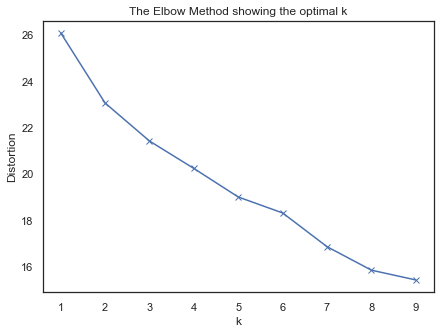

In [460]:
# variant 1 (using euclidian distance)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(no_food_grouped.drop('houseboat', 1))
    distortions.append(kmeanModel.inertia_)
 
 # plotting the elbow

plt.figure(figsize=(7,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()    

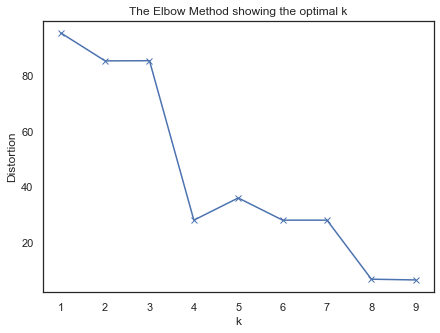

In [463]:
#variant 2 (using correlation distance)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(no_food_grouped.drop('houseboat', 1))
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(no_food_grouped.drop('houseboat', 1), kmeanModel.cluster_centers_, 'canberra'), axis=1)) / no_food_grouped.drop('houseboat', 1).shape[0])

 # plottting the elbow
plt.figure(figsize=(7,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

So, not good situation. Let's try to create **4 clusters**.

#### K-means clustering

In [411]:
# set number of clusters

kclusters = 4

no_food_venues_grouped_clustering = no_food_grouped.drop('houseboat', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(no_food_venues_grouped_clustering)

In [412]:
# check cluster labels generated for each row in the dataframe

kmeans.labels_

array([2, 1, 3, 3, 2, 3, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1,
       3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 3, 2, 1,
       3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 3, 2, 3, 0, 2,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 2, 1, 0, 3, 3, 2, 3, 2, 2, 3,
       1, 3, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 2, 3, 3, 1, 3, 1, 3, 1, 1, 1,
       3, 1, 3, 3, 1, 2, 2, 1])

In [413]:
# add clustering labels

no_food_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

no_food_merged = df

# merge food_grouped with common df to add latitude/longitude for each houseboat
no_food_merged = no_food_merged.join(no_food_neighborhoods_venues_sorted.set_index('houseboat'), on = 'houseboat')

#data cleaning
no_food_merged.dropna(axis = 0, inplace = True)
no_food_merged['Clusters'] = no_food_merged['Cluster Labels'].astype('int32')

no_food_merged.head() 

,houseboat,neighbourhood,latitude,longitude,price,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,,,,,
73917,B28 Unique Houseboat Herengracht,Centrum-West,52.378943,4.890602,175,94.0,1.0,Bike Rental / Bike Share,Squash Court,Canal,Zoo Exhibit,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,1
221943,Cozy Houseboat - Central Amsterdam,De Baarsjes - Oud-West,52.365637,4.876398,170,94.0,3.0,Gym / Fitness Center,Theater,Plaza,Cycle Studio,Bike Rental / Bike Share,Garden Center,Music Venue,Nightclub,Zoo Exhibit,Farm,3
627213,House boat near museums in the Pijp,De Pijp - Rivierenbuurt,52.352284,4.887419,150,100.0,3.0,Yoga Studio,Indie Movie Theater,Farm,Boutique,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,3
771217,Lovely Amsterdam Houseboat,Zuid,52.340747,4.850239,340,100.0,1.0,Tennis Court,Stadium,Harbor / Marina,Gym / Fitness Center,Gym,Skating Rink,Soccer Field,Zoo Exhibit,Dog Run,Concert Hall,1
779225,★★★★★ The Amsterdam Floating Mansion,Oostelijk Havengebied - Indische Buurt,52.369062,4.952069,350,95.0,1.0,Lounge,Pool,Arts & Entertainment,Harbor / Marina,Gym,Zoo Exhibit,Farm,Cruise Ship,Cycle Studio,Dance Studio,1


In [425]:
# create map

map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(no_food_merged['latitude'], no_food_merged['longitude'], no_food_merged['houseboat'], no_food_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In [415]:
# creating the dataframes for each clusters

no_food_cluster_0 = no_food_merged.loc[no_food_merged['Clusters'] == 0, no_food_merged.columns[[1] + list(range(5, no_food_merged.shape[1]))]]
no_food_cluster_1 = no_food_merged.loc[no_food_merged['Clusters'] == 1, no_food_merged.columns[[1] + list(range(5, no_food_merged.shape[1]))]]
no_food_cluster_2 = no_food_merged.loc[no_food_merged['Clusters'] == 2, no_food_merged.columns[[1] + list(range(5, no_food_merged.shape[1]))]]
no_food_cluster_3 = no_food_merged.loc[no_food_merged['Clusters'] == 3, no_food_merged.columns[[1] + list(range(5, no_food_merged.shape[1]))]]

### No_food Cluster 0

In [450]:
no_food_cluster_0.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
2800908,Oud-Noord,97.0,0.0,College Gym,VR Cafe,Garden,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,0
26376799,Oud-Noord,100.0,0.0,VR Cafe,Zoo Exhibit,Garden,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,0
26679161,Oud-Noord,100.0,0.0,College Gym,VR Cafe,Gym,Forest,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,0


In [451]:
no_food_cluster_0.shape

(3, 14)

In [417]:
# 1st Most Common Venues for no_food cluster 0

no_food_cluster_0_common = no_food_cluster_0.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
no_food_cluster_0_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
0,College Gym,2,2,2,2,2,2,2,2,2,2,2,2,2
1,VR Cafe,1,1,1,1,1,1,1,1,1,1,1,1,1


### No_food Cluster 1

In [452]:
no_food_cluster_1.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
73917,Centrum-West,94.0,1.0,Bike Rental / Bike Share,Squash Court,Canal,Zoo Exhibit,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,1
771217,Zuid,100.0,1.0,Tennis Court,Stadium,Harbor / Marina,Gym / Fitness Center,Gym,Skating Rink,Soccer Field,Zoo Exhibit,Dog Run,Concert Hall,1
779225,Oostelijk Havengebied - Indische Buurt,95.0,1.0,Lounge,Pool,Arts & Entertainment,Harbor / Marina,Gym,Zoo Exhibit,Farm,Cruise Ship,Cycle Studio,Dance Studio,1
791690,Centrum-West,99.0,1.0,Bike Rental / Bike Share,Yoga Studio,Canal,Zoo Exhibit,Garden,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,1
2787645,Watergraafsmeer,93.0,1.0,Circus,Park,Sports Club,Zoo Exhibit,Farm,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,1
2946162,Centrum-Oost,96.0,1.0,Scenic Lookout,Boat or Ferry,Jazz Club,History Museum,Climbing Gym,Harbor / Marina,Science Museum,Performing Arts Venue,Concert Hall,Dog Run,1
3408419,Watergraafsmeer,97.0,1.0,Garden,Harbor / Marina,Forest,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,1
5836389,IJburg - Zeeburgereiland,94.0,1.0,Coworking Space,Harbor / Marina,Pier,Park,Neighborhood,Farm,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,1
6455099,Zuid,98.0,1.0,Tennis Court,Harbor / Marina,Boat or Ferry,Gym / Fitness Center,Stadium,Soccer Field,Forest,Farm,Coworking Space,Cruise Ship,1


In [419]:
# 1st Most Common Venues for no_food cluster 1

no_food_cluster_1_common = no_food_cluster_1.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
no_food_cluster_1_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
5,Coworking Space,8,8,8,8,8,8,8,8,8,8,8,8,8
20,Tennis Court,5,5,5,5,5,5,5,5,5,5,5,5,5
11,Lounge,3,3,3,3,3,3,3,3,3,3,3,3,3
8,Harbor / Marina,3,3,3,3,3,3,3,3,3,3,3,3,3
9,Indie Movie Theater,3,3,3,3,3,3,3,3,3,3,3,3,3
19,Scenic Lookout,2,2,2,2,2,2,2,2,2,2,2,2,2
4,Circus,2,2,2,2,2,2,2,2,2,2,2,2,2
17,Pool,2,2,2,2,2,2,2,2,2,2,2,2,2
1,Bike Rental / Bike Share,2,2,2,2,2,2,2,2,2,2,2,2,2
14,Pier,1,1,1,1,1,1,1,1,1,1,1,1,1


### No_food Cluster 2

In [454]:
no_food_cluster_2.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
1079499,Oud-Oost,98.0,2.0,Yoga Studio,Gym / Fitness Center,Playground,Waterfront,College Arts Building,Gym,Performing Arts Venue,Park,Zoo Exhibit,Dog Run,2
1927634,Oostelijk Havengebied - Indische Buurt,97.0,2.0,Yoga Studio,Gym / Fitness Center,Park,Bookstore,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,2
1943465,De Baarsjes - Oud-West,94.0,2.0,Yoga Studio,Movie Theater,Gym / Fitness Center,Garden Center,Dance Studio,Health & Beauty Service,Bookstore,Forest,Cruise Ship,Cycle Studio,2
3163509,Centrum-Oost,99.0,2.0,Yoga Studio,College Arts Building,Waterfront,Theater,Gym,Forest,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,2
4610921,De Baarsjes - Oud-West,91.0,2.0,Yoga Studio,Garden Center,Garden,Coworking Space,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,2
4806556,De Baarsjes - Oud-West,96.0,2.0,Yoga Studio,Bookstore,Movie Theater,Beer Garden,Garden Center,Garden,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,2
5374067,Oud-Oost,98.0,2.0,Yoga Studio,Gym / Fitness Center,Waterfront,College Arts Building,Lounge,Gym,Performing Arts Venue,Park,Zoo Exhibit,Event Space,2
6664240,Oud-Oost,100.0,2.0,Gym / Fitness Center,Performing Arts Venue,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,Dog Run,2
6867245,De Baarsjes - Oud-West,100.0,2.0,Yoga Studio,Bookstore,Playground,Dance Studio,Movie Theater,Beer Garden,Farm,Garden Center,Garden,Cycle Studio,2


In [421]:
# 1st Most Common Venues for no_food cluster 2

no_food_cluster_2_common = no_food_cluster_2.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
no_food_cluster_2_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
1,Yoga Studio,22,22,22,22,22,22,22,22,22,22,22,22,22
0,Gym / Fitness Center,2,2,2,2,2,2,2,2,2,2,2,2,2


### No_food Cluster 3

In [456]:
no_food_cluster_3.head(10)

,neighbourhood,review_scores_rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
id,,,,,,,,,,,,,,
221943,De Baarsjes - Oud-West,94.0,3.0,Gym / Fitness Center,Theater,Plaza,Cycle Studio,Bike Rental / Bike Share,Garden Center,Music Venue,Nightclub,Zoo Exhibit,Farm,3
627213,De Pijp - Rivierenbuurt,100.0,3.0,Yoga Studio,Indie Movie Theater,Farm,Boutique,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,3
839139,Centrum-West,100.0,3.0,Pool,Indie Movie Theater,Plaza,Gym,Canal,Music Venue,Farm,Cruise Ship,Cycle Studio,Dance Studio,3
1381448,Westerpark,98.0,3.0,Indie Movie Theater,Music Venue,Plaza,Event Space,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,3
1756765,De Baarsjes - Oud-West,93.0,3.0,Gym / Fitness Center,Movie Theater,Bookstore,Rock Club,Dance Studio,Music Venue,Pool Hall,Health & Beauty Service,Yoga Studio,Harbor / Marina,3
2224736,Centrum-West,92.0,3.0,Music Venue,Bike Rental / Bike Share,Museum,Plaza,Art Gallery,Arcade,Indie Movie Theater,Garden,Cycle Studio,Dance Studio,3
2368869,Centrum-West,95.0,3.0,Plaza,Squash Court,Indie Movie Theater,Canal,Boarding House,Zoo Exhibit,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,3
2957820,Westerpark,95.0,3.0,Indie Movie Theater,Plaza,Music Venue,Event Space,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,3
3144548,Oostelijk Havengebied - Indische Buurt,97.0,3.0,Plaza,Playground,Tunnel,Zoo Exhibit,Forest,Cruise Ship,Cycle Studio,Dance Studio,Design Studio,Distillery,3


In [423]:
# 1st Most Common Venues for no_food cluster 3

no_food_cluster_3_common = no_food_cluster_3.groupby(by = '1st Most Common Venue', as_index = False).count().sort_values(by = 'Clusters', ascending = False)
no_food_cluster_3_common

,1st Most Common Venue,neighbourhood,review_scores_rating,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
7,Indie Movie Theater,8,8,8,8,8,8,8,8,8,8,8,8,8
11,Plaza,8,8,8,8,8,8,8,8,8,8,8,8,8
0,Bookstore,6,6,6,6,6,6,6,6,6,6,6,6,6
9,Movie Theater,5,5,5,5,5,5,5,5,5,5,5,5,5
16,Yoga Studio,4,4,4,4,4,4,4,4,4,4,4,4,4
5,Gym / Fitness Center,2,2,2,2,2,2,2,2,2,2,2,2,2
8,Jazz Club,2,2,2,2,2,2,2,2,2,2,2,2,2
12,Pool,2,2,2,2,2,2,2,2,2,2,2,2,2
17,Zoo Exhibit,2,2,2,2,2,2,2,2,2,2,2,2,2
4,Dance Studio,1,1,1,1,1,1,1,1,1,1,1,1,1


#### Plot to visualize the frequency of differet venues in each no_food cluster

In [424]:
#dataframe formation

no_food_venues_number = no_food_merged
no_food_venues_number = no_food_venues_number.drop(['neighbourhood','latitude', 'longitude', 'price', 'review_scores_rating', 'Cluster Labels'], axis = 1)
no_food_venues_number = no_food_venues_number.groupby(['Clusters','1st Most Common Venue']).size().reset_index(name = 'number')

#transposing the dataframe

no_food_clusters = no_food_venues_number.pivot(index = 'Clusters', columns = '1st Most Common Venue', values = 'number')
no_food_clusters = no_food_clusters.fillna(0).astype(int).reset_index(drop = True)
no_food_clusters

1st Most Common Venue,Baseball Field,Bike Rental / Bike Share,Bookstore,Boutique,Canal,Canal Lock,Circus,College Arts Building,College Gym,Comedy Club,Coworking Space,Dance Studio,Garden,General Entertainment,Gym / Fitness Center,Harbor / Marina,History Museum,Indie Movie Theater,Jazz Club,Lake,Lounge,Movie Theater,Music Venue,Nightclub,Park,Pier,Playground,Plaza,Pool,Pool Hall,Road,Scenic Lookout,Squash Court,Tennis Court,Theme Park Ride / Attraction,VR Cafe,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,2,0,0,1,1,2,0,0,0,8,0,1,1,0,3,0,3,0,1,3,0,0,1,1,1,1,1,2,0,1,2,0,5,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0
3,0,0,6,1,0,0,0,1,0,1,0,1,0,0,2,0,1,8,2,0,0,5,1,0,0,0,0,8,2,1,0,0,1,0,1,0,4,2


Text(0, 0.5, 'No_Food Venue Count')

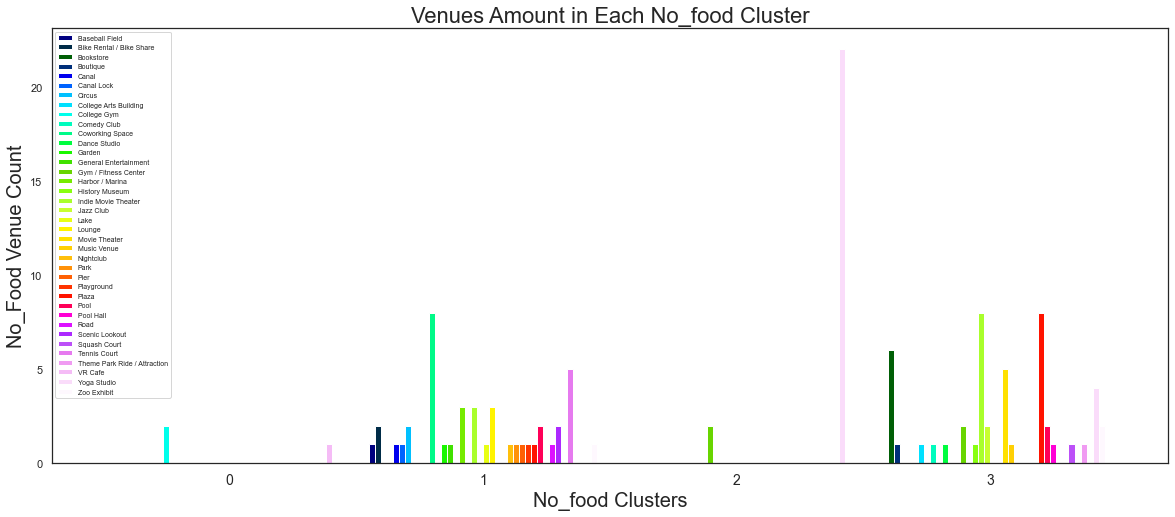

In [430]:
# bar chart with the "Number of Venues in Each No_food Cluster"

no_food_graph = no_food_clusters.plot(kind = 'bar', figsize = (20,8), width = 0.9, colormap = 'gist_ncar')

plt.legend(labels = no_food_clusters.columns, fontsize = 7)
plt.title("Venues Amount in Each No_food Cluster", fontsize = 22)
plt.xticks(fontsize = 14)
plt.xticks(rotation = 0)
plt.xlabel('No_food Clusters', fontsize = 20)
plt.ylabel('No_Food Venue Count', fontsize = 20)

## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>